In [2]:
import pandas as pd
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lets_plot import *
from lets_plot.mapping import as_discrete
import plotnine as p9
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import KNeighborsRegressor,NearestNeighbors
from joblib import Parallel, delayed
from toolz import partial
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm


LetsPlot.setup_html()

# CAPITOL 5: ATE CALCULATION WITH PROPENSITY SCORE

# 1.GETTING THE ATE WITH A CONTINUOUS TREATMENT(DEFAULT CASE)


## 1.1.DATA EXPLORATION
Checking if there is any null value:

In [3]:
dataset_continuous=pd.read_csv("risk_data.csv")

In [4]:
print(dataset_continuous.isnull().sum())
print("shape: " + str(dataset_continuous.shape))

wage             0
educ             0
exper            0
married          0
credit_score1    0
credit_score2    0
credit_limit     0
default          0
dtype: int64
shape: (50000, 8)


In [5]:
dataset_continuous.describe()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
count,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1061.518000,13.48886,11.55078,0.896120,471.102540,487.861920,2848.570000,0.150800
std,412.304605,2.20769,4.36497,0.305108,113.401589,117.063919,1372.623633,0.357857
min,120.000000,9.00000,1.00000,0.000000,34.000000,36.000000,200.000000,0.000000
25%,770.000000,12.00000,8.00000,1.000000,397.000000,411.000000,1900.000000,0.000000
50%,1010.000000,12.00000,11.00000,1.000000,466.000000,482.000000,2700.000000,0.000000
75%,1270.000000,16.00000,15.00000,1.000000,534.000000,571.000000,3700.000000,0.000000
max,3310.000000,18.00000,23.00000,1.000000,1034.000000,1036.000000,8500.000000,1.000000


Identifying continuous and discrete variables:

In [6]:
num_unique_values = dataset_continuous.nunique()
# Iterate over the columns and print the number of unique values
for column, num_values in num_unique_values.items():
    print(f"{column}: {num_values}")
    
print(dataset_continuous.shape)

wage: 308
educ: 10
exper: 22
married: 2
credit_score1: 59
credit_score2: 55
credit_limit: 83
default: 2
(50000, 8)


### CORRELATIONS
I decided to compute correlations between variables with 1 function that has into account the type of variables. This function contemplates 3 cases:
- **Relation between 2 binary variables**: it uses the chi-square test to refuse the null hypothesis, the 2 variables don't have relation.
- **Relation between a continuous variables and a binary one**: the correlation is computed with point-biserial.
- **Relation between 2 continuous variables**: it is used Pearson metric.

Furthermore, I decided to use also corr() from pandas library and I plot 2 
heatmaps to compare the results. 

**It is possible to observe that the heatmaps are equal.**

married-default P-value: 6.828078237345712e-07
default-married P-value: 6.828078237345712e-07


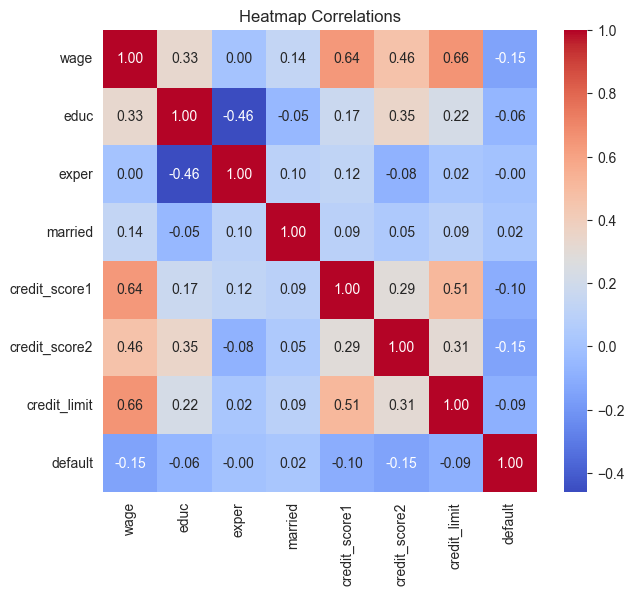

In [7]:
def calculate_correlation_matrix(df):
    corr_matrix = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                if len(df[col1].unique()) == 2 and len(df[col2].unique()) == 2:
                    # Both columns are binary, so it is used chi2 test to verify h0 = they don't have relationship or H1 = they have it
                    contingency_table = pd.crosstab(df[col1], df[col2])
                    chi2, p_value, _, _ = chi2_contingency(contingency_table)
                    print(f"{col1}-{col2} P-value: {p_value}")
                    # normalizing the chi square result
                    corr = np.sqrt(chi2 / df.shape[0])
                    
                elif pd.api.types.is_numeric_dtype(df[col1]) and len(df[col2].unique()) == 2 or pd.api.types.is_numeric_dtype(df[col2]) and len(df[col1].unique()) == 2:
                    # One column is continuous and the other is binary
                    corr, _ = pointbiserialr(df[col2], df[col1])
                elif pd.api.types.is_numeric_dtype(df[col1]) and pd.api.types.is_numeric_dtype(df[col2]):
                    # Both columns are continuous
                    if len(df[col1].unique()) > 2 and len(df[col2].unique()) > 2:
                        corr, _ = pearsonr(df[col1], df[col2])
                
                corr_matrix.loc[col1, col2] = corr
                
    return corr_matrix

corr_matrix = calculate_correlation_matrix(dataset_continuous)
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Correlations')
plt.show()


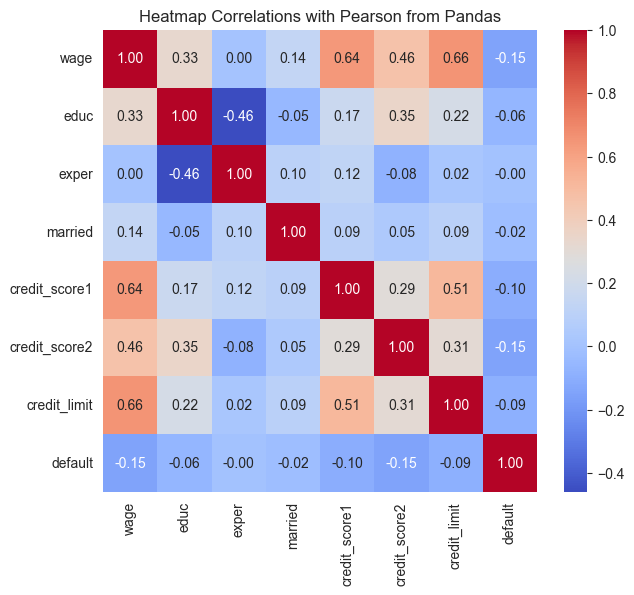

In [8]:
# by default, it computes Pearson correlation
correlation_matrix_pandas = dataset_continuous.corr()
plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix_pandas, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Correlations with Pearson from Pandas')
plt.show()

Analysing the correlation matrix, **the top 3 variables with strong relation with credit_limit and default are wage, credit_score1 and credit_score2**. 

Next plot shows how **wage, credit_score1 and credit_Score2 have a strong relation with  credit_limit and explain the big coefficients on the correlation matrix**.

In [9]:
(ggplot(dataset_continuous, aes(x='wage', y='credit_limit', color=as_discrete('default'))) +
 geom_point() +
 ggmarginal("t", layer=geom_density()))

In [10]:
(ggplot(dataset_continuous, aes(x='credit_score1', y='credit_limit', color=as_discrete('default'))) +
 geom_point() +
 ggmarginal("t", layer=geom_density()))

In [11]:
(ggplot(dataset_continuous, aes(x='credit_score2', y='credit_limit', color=as_discrete('default'))) +
 geom_point() +
 ggmarginal("t", layer=geom_density()))

Using a boxplot graphs with notches is possible to verify if there is difference between the averages of credit_limit, credit_score1, credit_score2 of people who default and the averages for the same variables of people who do not default. With a level of 95% of confidence it is possible to refuse of null hypothesis in all the cases.**In all the cases the averages are different**. Moreover,all the cases have narrow notches, that means a high precision on the means calculations. Overall, **while people who default tend to have bigger credit_limits, credit_score1, credit_score2 and wage than who do not default, the difference seems to not be significant explaining the low relation coefficients on the correlation matrix**.

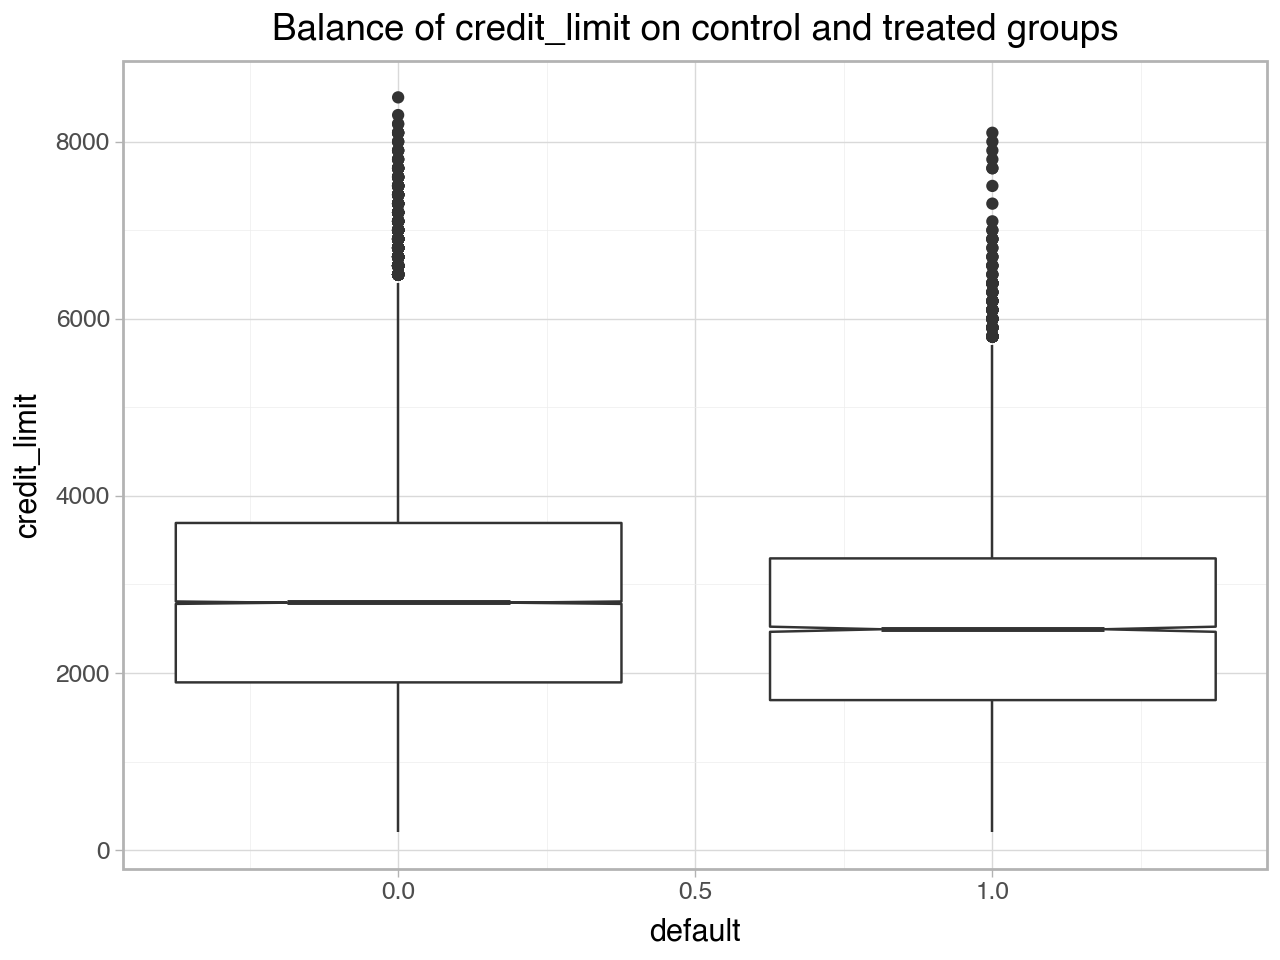

In [12]:
plot = (
    p9.ggplot(dataset_continuous, p9.aes(x='default', y='credit_limit', group='default'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("Balance of credit_limit on control and treated groups")
)
plot.show()

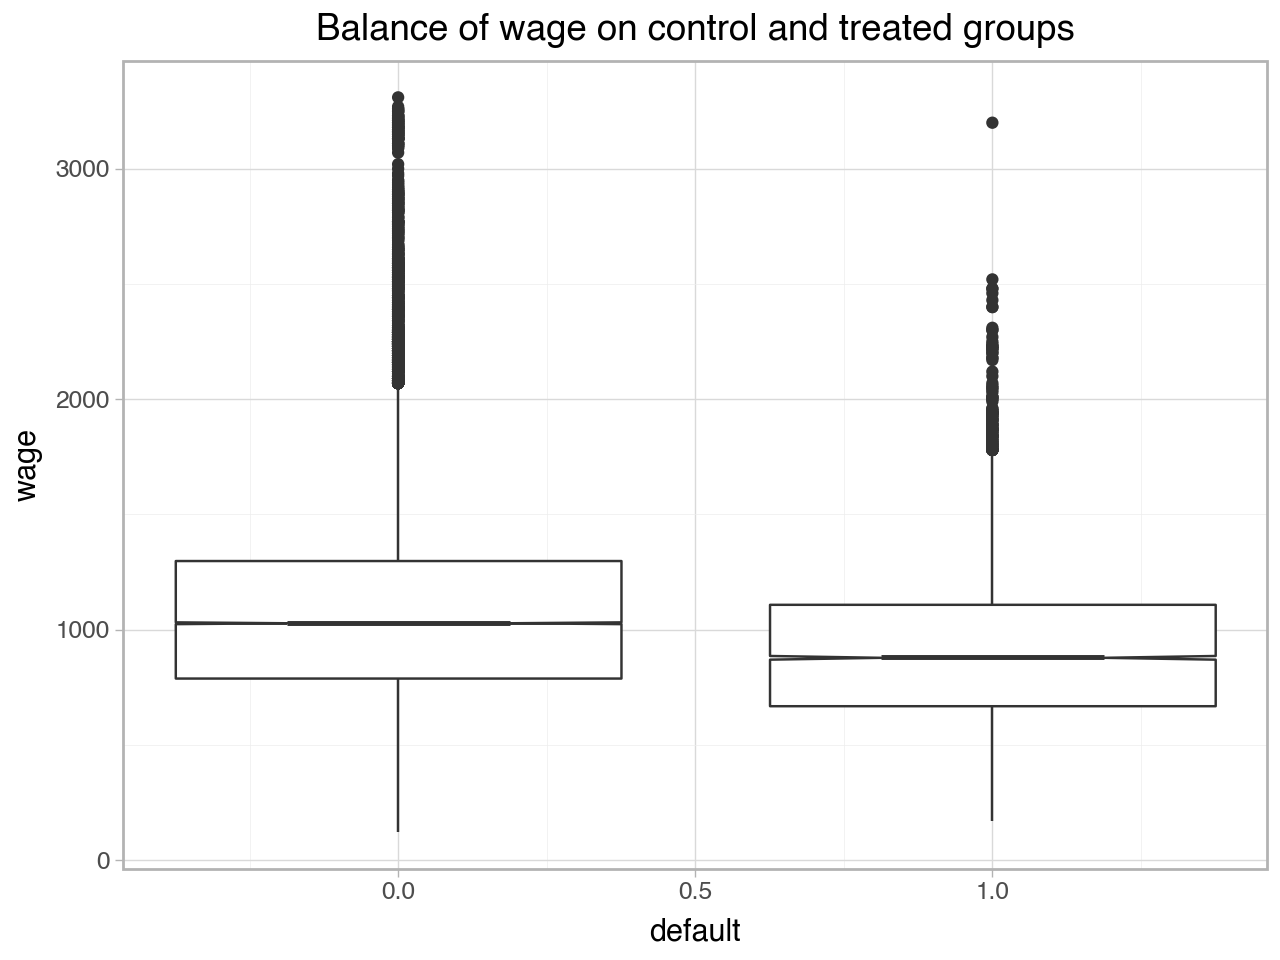

In [13]:
plot = (
    p9.ggplot(dataset_continuous, p9.aes(x='default', y='wage', group='default'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("Balance of wage on control and treated groups")
)
plot.show()

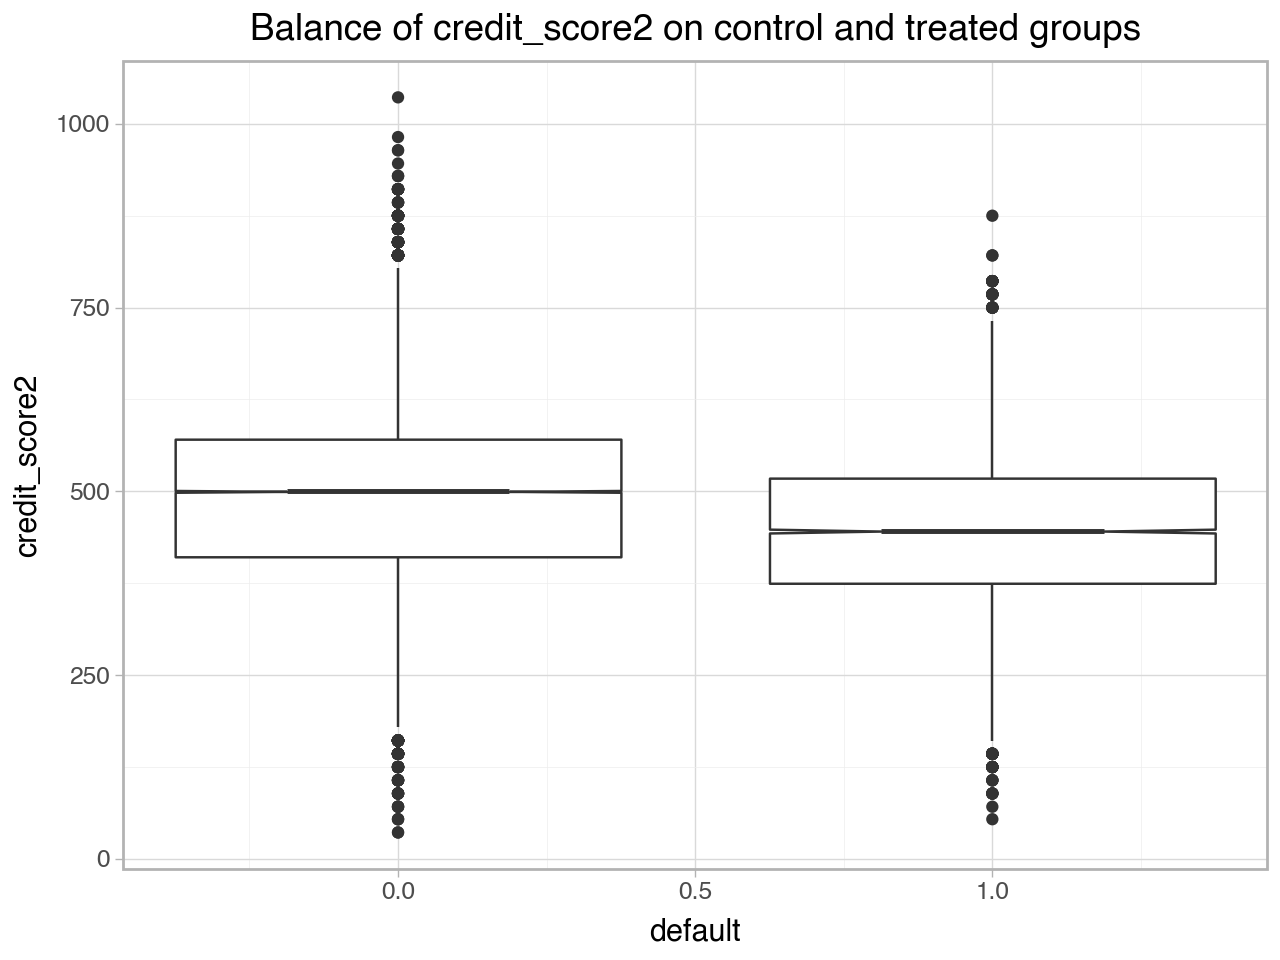

In [14]:
plot = (
    p9.ggplot(dataset_continuous, p9.aes(x='default', y='credit_score2', group='default'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("Balance of credit_score2 on control and treated groups")
)
plot.show()

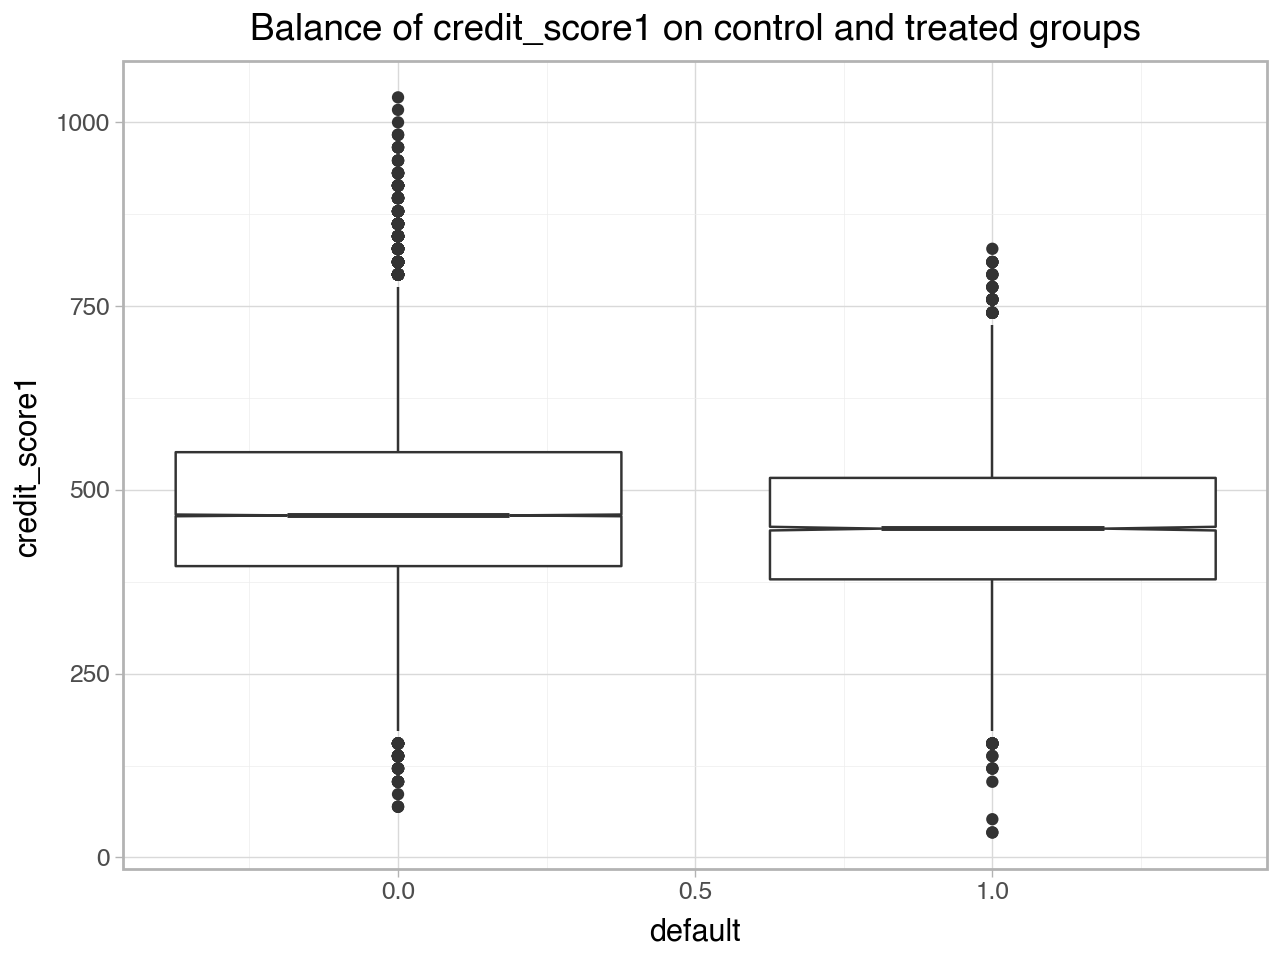

In [15]:
plot = (
    p9.ggplot(dataset_continuous, p9.aes(x='default', y='credit_score1', group='default'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("Balance of credit_score1 on control and treated groups")
)
plot.show()

## 1.2. GETTING THE GPS(Generalized Propensity Score)
As the treatment is continuous, PS change to GPS(Generalized Propensity Score) that is obtained by the conditional density function of the treatment.

The next scenarios are set to get the GPS with continuous treatment using different model types:
1. **Lineal regression**
2. **Generalized Boosted Model: XGBoosting**

The first scenario is proposed by Matheus Facure in page 169 of his book [Causal Inference in Python](https://dokumen.pub/causal-inference-in-python-applying-causal-inference-in-the-tech-industry-1nbsped-1098140257-9781098140250.html).

The second scenario is based on the article [A Boosting Algorithm for Estimating Generalized Propensity Scores with Continuous Treatments](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4749263/) by Yeying Zhu,Donna L. Coffman, and Debashis Ghosh. XGBoosting can be used as it is a boosting algorithm to prediction. In addition, it performs better with large number of covariates. IMPORTANT the parameter of number of trees determines the trade-off between bias and variance of causal estimator which obtains the ATE,

In [16]:
covariates_x=['credit_score1', 'credit_score2', 'wage']
x_for_continuous_t=dataset_continuous[covariates_x]
continuous_treatment_t=dataset_continuous[['credit_limit']]

In [17]:
def conditional_density(x,mean,std):
    denom = std*np.sqrt(2*np.pi)
    num = np.exp(-((1/2)*((x-mean)/std)**2)) 
    return (num/denom).ravel()

### 1.2.1. Linear regression

Training a Linear Regression model to obtain the mean of the treatment predicted and its standard error to define the conditional density function. With the density function is possible to get the GPS. 

In [18]:
linear_reg_model=LinearRegression()
linear_reg_model.fit(x_for_continuous_t, continuous_treatment_t)

LinearRegression()

In [19]:
linear_reg_predictions=linear_reg_model.predict(x_for_continuous_t)

dataset_continuous['linear_reg_gps']=(conditional_density
                                            (dataset_continuous['credit_limit'], linear_reg_predictions.mean(),linear_reg_predictions.std()))

dataset_continuous['linear_reg_gps'].head()

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/2631092449.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.


0    0.000405
1    0.000198
2    0.000147
3    0.000147
4    0.000226
Name: linear_reg_gps, dtype: float64

### 1.2.2.Generalized Boosted Model: XGBoosting
 The process to obtain the GPS is equal to the previous process with a Linear Regression model.

In [20]:
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(x_for_continuous_t, continuous_treatment_t)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
xgb_pred=xgb_model.predict(x_for_continuous_t)

In [22]:
xgb_gps= conditional_density(dataset_continuous['credit_limit'],xgb_pred.mean(),xgb_pred.std())

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/2631092449.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.


In [23]:
dataset_continuous['xgb_gps']=xgb_gps
dataset_continuous['xgb_gps'].head()

0    0.000384
1    0.000204
2    0.000156
3    0.000157
4    0.000229
Name: xgb_gps, dtype: float64

## 1.3. GPS MATCHING

For this technic is used the GPS calculated by the Regression Model.

To do the matching, the dataset is divided into 2 groups: low credit limit and high credit limit relative to the median credit limit. Units with low credit_limit will be matched with units with high credit limit based on their GPS.

In [24]:
median_credit_limit = dataset_continuous['credit_limit'].median()

dataset_continuous['high_credit_limit']=dataset_continuous['credit_limit'].apply(lambda x: 1 if x > median_credit_limit else 0)

For the PS matching, or GPS in continuous treatment, it will be defined 2 function, one with adjustment logistic regression and another without adjustment.

In [25]:
def ate_ps_matching_with_adjustment(df, column_treatment_name:str, column_propensity_score_name:str, column_outcome_name:str, list_covariables_names, is_binary_outcome=True):
    
    # Model to match control units with treated units based on PS
    knn_treated = NearestNeighbors(n_neighbors=1)
    knn_treated.fit(df.query(f'{column_treatment_name}==1')[[column_propensity_score_name]])
    
    # Getting the indexes of the units with treatment that match the PS of units without treatment
    _, matched_index = knn_treated.kneighbors(df.query(f'{column_treatment_name}==0')[[column_propensity_score_name]])
    
    # Getting indexes relative to the dataset of treated units
    treated_index = df.index[df[column_treatment_name] == 1].tolist()
    
    treated_units_matched_with_control_units=[]
    
    # The index of the treated units matched with the control units but relative to the DataFrame and not relative to the units used to train KNN
    for idx in matched_index.flatten():
         treated_units_matched_with_control_units.append(treated_index[idx])
         
    # Model to match treated units with control units based on PS
    knn_control = NearestNeighbors(n_neighbors=1)
    knn_control.fit(df.query(f'{column_treatment_name}==0')[[column_propensity_score_name]])

    _, matched_index = knn_control.kneighbors(df.query(f'{column_treatment_name}==1')[[column_propensity_score_name]])
    
    control_units_matched_with_treatment_units=[]
    
    # Getting indexes relative to dataset of control units
    control_index = df.index[df[column_treatment_name] == 0].tolist()
    
    # The index of the treated units matched with the control units but relative to the DataFrame and not relative to the units used to train KNN
    for idx in matched_index.flatten():
         control_units_matched_with_treatment_units.append(control_index[idx])
        
    # Outcome models
    if is_binary_outcome:
        regression_treated = LogisticRegression().fit(df.query(f'{column_treatment_name}==1')[list_covariables_names], df.query(f'{column_treatment_name}==1')[[column_outcome_name]])
        regression_control = LogisticRegression().fit(df.query(f'{column_treatment_name}==0')[list_covariables_names], df.query(f'{column_treatment_name}==0')[[column_outcome_name]])
    else:
        regression_treated = LinearRegression().fit(df.query(f'{column_treatment_name}==1')[list_covariables_names], df.query(f'{column_treatment_name}==1')[[column_outcome_name]])
        regression_control = LinearRegression().fit(df.query(f'{column_treatment_name}==0')[list_covariables_names], df.query(f'{column_treatment_name}==0')[[column_outcome_name]])
    
    # Difference between potential outcomes by regressions
    diff_potential_outcomes0_treated_units = regression_control.predict(df.loc[treated_index][list_covariables_names]) - regression_control.predict(df.loc[control_units_matched_with_treatment_units][list_covariables_names])
    diff_potential_outcomes1_control_units = regression_treated.predict(df.loc[treated_units_matched_with_control_units][list_covariables_names]) - regression_treated.predict(df.loc[control_index][list_covariables_names])
    
    # Differences between outcomes from knn matches
    diff_outcomes_between_treated_and_matches = df.loc[treated_index, column_outcome_name].values - df.loc[control_units_matched_with_treatment_units, column_outcome_name].values
    dif_outcomes_between_control_and_matches = df.loc[control_index, column_outcome_name].values - df.loc[treated_units_matched_with_control_units, column_outcome_name].values
    
    ate = (np.sum(diff_outcomes_between_treated_and_matches - diff_potential_outcomes0_treated_units) +
           np.sum(dif_outcomes_between_control_and_matches - diff_potential_outcomes1_control_units)) / df.shape[0]
    
    return ate


In [26]:
def ate_ps_matching_without_adjustment(df,treatment, propensity_score, outcome):
    T = treatment
    X = propensity_score
    Y = outcome
    treated = df.query(f"{T}==1")
    untreated = df.query(f"{T}==0")
    mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[[X]],
                                             untreated[Y])
    
    mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[[X]], treated[Y])
    predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model 
        treated.assign(match=mt0.predict(treated[[X]])),
        # find matches for the untreated looking at the treated knn model
        untreated.assign(match=mt1.predict(untreated[[X]]))
    ])
    
    return np.mean((predicted[Y] - predicted["match"])*predicted[T]
                    + (predicted["match"] - predicted[Y])*(1-predicted[T]))


To calculate the confidences intervals around ATE calculations, it will be used a bootstrapping function:

In [27]:
def bootstrap(data, est_fn, rounds=200, seed=123, pcts=[2.5, 97.5]):
    
    np.random.seed(seed)
    
    # list compression  with ATEs
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(data.sample(frac=1, replace=True))# setting the func to be executed parallely ti data.sample as first param
        for _ in range(rounds) 
    )
    
    
    return np.percentile(stats, pcts)

ATEs calculations with confidence intervals:

In [28]:
partial_gps_matching_without_adjustment_func = partial(ate_ps_matching_without_adjustment,treatment='high_credit_limit',propensity_score='linear_reg_gps',outcome='default')

print(f'ATE gps matching WITHOUT adjustment:{partial_gps_matching_without_adjustment_func(dataset_continuous)} with 95% confidence interval:{bootstrap(dataset_continuous,partial_gps_matching_without_adjustment_func)}')

ATE gps matching WITHOUT adjustment:-0.01594 with 95% confidence interval:[-0.188359  0.077575]


In [29]:
partial_gps_matching_adjusted_func = partial(ate_ps_matching_with_adjustment,column_treatment_name='high_credit_limit',column_propensity_score_name='linear_reg_gps',column_outcome_name='default', list_covariables_names=covariates_x,
                                             is_binary_outcome=True)

print(f'ATE gps matching with adjustment:{partial_gps_matching_adjusted_func(dataset_continuous)} ')
print(f'95% confidence interval:{bootstrap(dataset_continuous,partial_gps_matching_adjusted_func)}')

/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ATE gps matching with adjustment:0.0573 


/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWar

ValueError: operands could not be broadcast together with shapes (49662,) (48968,) 

## 1.4. IPW WITH LINEAR REGRESSION GPS

As the treatment is continuous, first, **it is going to be calculated the marginal density of the treatment to stable the weights**.

In [31]:
density_t=conditional_density(dataset_continuous['credit_limit'],
                              dataset_continuous['credit_limit'].mean(),
                              dataset_continuous['credit_limit'].std())

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/2631092449.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.


In [32]:
def ipw_ate_stabilized(df, T, Y, gps):
    stabilizer = norm(
        loc=df[T].mean(),
        scale=np.std(df[T] - df[T].mean())
    ).pdf(df[T])
    
    weights = stabilizer / gps

    logit_model = smf.logit(f"{Y}~{T}", data=df)
    result = logit_model.fit_regularized(weights=weights)
    
    return result.params[T]


print(f'ATE IPW stabilized:{ipw_ate_stabilized(dataset_continuous,"credit_limit","default",dataset_continuous["linear_reg_gps"])}')

partial_ipw=partial(ipw_ate_stabilized,T="credit_limit",Y="default",gps=dataset_continuous["linear_reg_gps"])

print(f'95% Confidence Intervals{bootstrap(dataset_continuous,partial_ipw)}')

/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.41971017024960217
            Iterations: 12
            Function evaluations: 22
            Gradient evaluations: 12
ATE IPW stabilized:-0.00019743376014685936


/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/gerard/Desktop/sdg/sharedGit/venv/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/gerard/Desktop

95% Confidence Intervals[-0.00021583 -0.00017759]


It seems that credit_limit influence over default is tiny.**For each unit increase of credit_limit, default decrease 0.00011.**

## 1.5. LOGISTIC REGRESSION

ATE calculation using a Logistic regression with default as objective and conditioning treatment, credit_limit, and covariables:

In [33]:
print(f"default ~ credit_limit + {'+'.join(covariates_x)}")

logit_model=smf.glm(formula=f"default ~ credit_limit + {'+'.join(covariates_x)}", data=dataset_continuous, family=sm.families.Binomial()).fit()

print(f"ATE:{logit_model.params['credit_limit']}")
print(f"95% Confidence Intervals {logit_model.conf_int()}")

default ~ credit_limit + credit_score1+credit_score2+wage
ATE:2.9851463043686503e-05
95% Confidence Intervals                       0         1
Intercept      0.256954  0.528715
credit_limit   0.000005  0.000055
credit_score1 -0.000624 -0.000045
credit_score2 -0.002619 -0.002141
wage          -0.001039 -0.000827


It is obtained ATE=0.00003 with [0.000005,  0.000055] confidence intervals 95%.

# 2.GETTING THE ATE WITH A BINARY TREATMENT
It is going to be compared the ATE of 2 treatments, short email and long email, over the outcome conversion.

## 2.1. DATA EXPLORATION

In [34]:
dataset_binary=pd.read_csv("cross_sell_email.csv")
dataset_binary.head()

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


Coding the treatment:

In [35]:
dataset_binary_coded=pd.get_dummies(dataset_binary, columns=['cross_sell_email'], drop_first=False)
dataset_binary_coded.head()

,gender,age,conversion,cross_sell_email_long,cross_sell_email_no_email,cross_sell_email_short
0,0,15,0,False,False,True
1,1,27,0,False,False,True
2,1,17,0,True,False,False
3,1,34,0,True,False,False
4,1,14,0,False,True,False


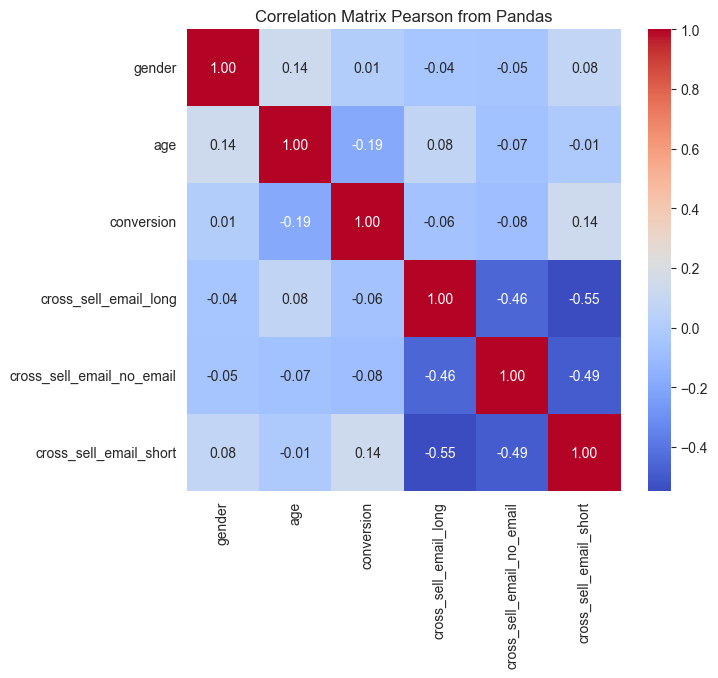

In [36]:
# by default, it computes Pearson correlation
correlation_matrix_pandas = dataset_binary_coded.corr()
plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix_pandas, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Pearson from Pandas')
plt.show()

gender-conversion P-value: 0.9911451147146538
gender-cross_sell_email_long P-value: 0.5346434750363807
gender-cross_sell_email_no_email P-value: 0.46862280552133495
gender-cross_sell_email_short P-value: 0.1598765731104852
conversion-gender P-value: 0.9911451147146538
conversion-cross_sell_email_long P-value: 0.39378861757597683
conversion-cross_sell_email_no_email P-value: 0.20326423502897065
conversion-cross_sell_email_short P-value: 0.024708032351884988
cross_sell_email_long-gender P-value: 0.5346434750363807
cross_sell_email_long-conversion P-value: 0.39378861757597683
cross_sell_email_long-cross_sell_email_no_email P-value: 6.053490526308852e-16
cross_sell_email_long-cross_sell_email_short P-value: 2.0375138851366545e-22
cross_sell_email_no_email-gender P-value: 0.46862280552133495
cross_sell_email_no_email-conversion P-value: 0.20326423502897054
cross_sell_email_no_email-cross_sell_email_long P-value: 6.053490526308852e-16
cross_sell_email_no_email-cross_sell_email_short P-value:

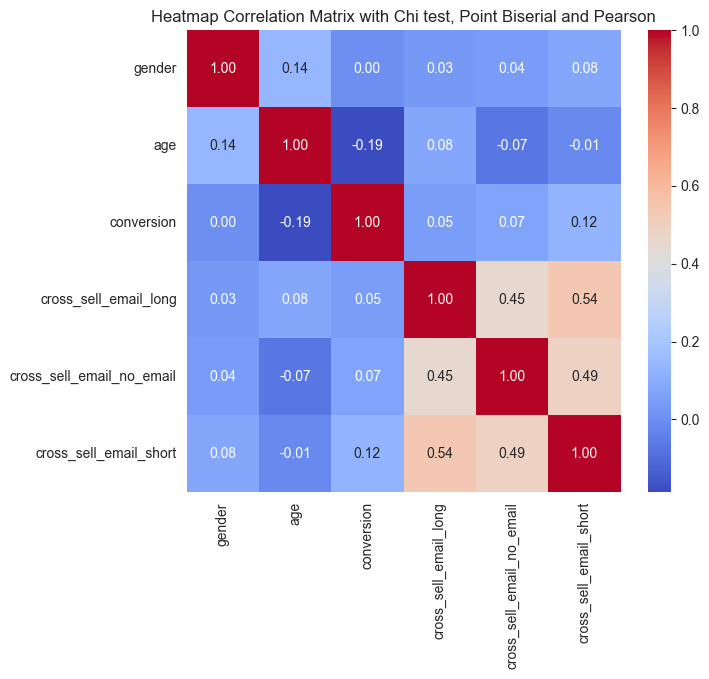

In [37]:
corr_matrix = calculate_correlation_matrix(dataset_binary_coded)
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Correlation Matrix with Chi test, Point Biserial and Pearson')
plt.show()

In this case seems that the correlations calculated by Pandas, that uses only Pearson by default, are different from the ones calculated by the function that has into account the type of the variables to calculate their correlations. However, the difference are not significant and the cases where only has changed the sign are due to chi-test which only calculates the strength of the relation.

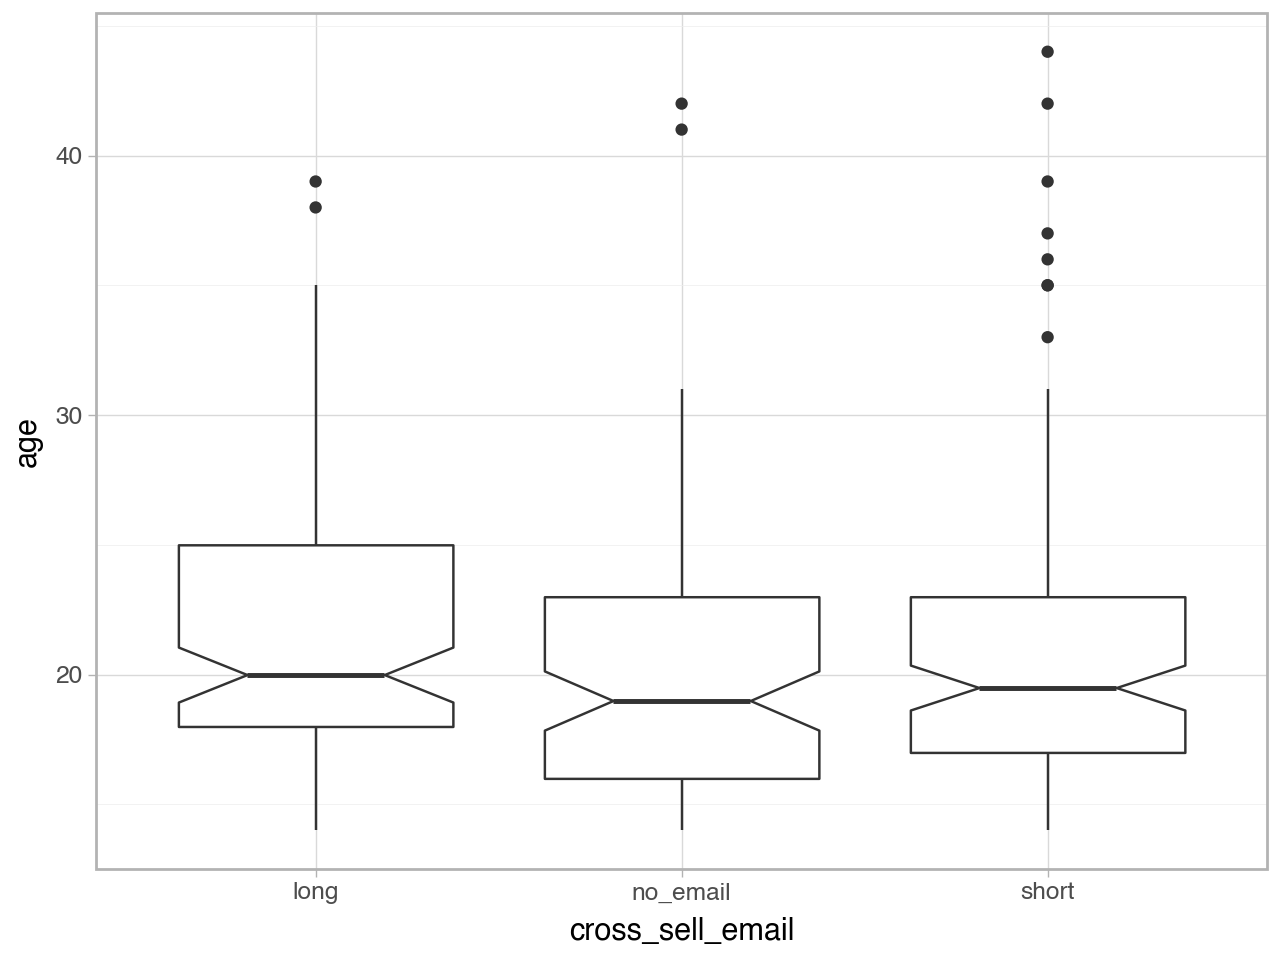

In [38]:
plot = (
    p9.ggplot(dataset_binary, p9.aes(x='cross_sell_email', y='age', group='cross_sell_email'))
    + p9.geom_boxplot(notch=True)
    + p9.theme_light()
    + p9.ggtitle("")
)
plot.show()

## 2.2. PS CALCULATION

In [39]:
covariables_x_for_binary=['age', 'gender']
dataset_short_mail=dataset_binary_coded.query("cross_sell_email_short==1 or cross_sell_email_no_email==1")
dataset_long_mail=dataset_binary_coded.query("cross_sell_email_long==1 or cross_sell_email_no_email==1")

### 2.2.1. Logistic Regression

In [40]:
# for short emails
logit_model_short_emails=LogisticRegression()
logit_model_short_emails.fit(dataset_short_mail[covariables_x_for_binary], dataset_short_mail['cross_sell_email_short'])

# the model returns 2 columns with probabilities for 0 and 1, it is only needed prob for 1 
dataset_short_mail['logit_model_short_ps']= logit_model_short_emails.predict_proba(dataset_short_mail[covariables_x_for_binary])[:, 1]

dataset_short_mail.head()

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/2258160689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,gender,age,conversion,cross_sell_email_long,cross_sell_email_no_email,cross_sell_email_short,logit_model_short_ps
0,0,15,0,False,False,True,0.493930
1,1,27,0,False,False,True,0.612981
4,1,14,0,False,True,False,0.573943
5,0,17,1,False,True,False,0.500156
7,1,19,1,False,False,True,0.589095


In [41]:
#for long emails
logit_model_long_emails=LogisticRegression()
logit_model_long_emails.fit(dataset_long_mail[covariables_x_for_binary], dataset_long_mail['cross_sell_email_long'])

# the model returns 2 columns with probabilities for 0 and 1, it is only needed prob for 1 
dataset_long_mail['logit_model_long_ps']= logit_model_long_emails.predict_proba(dataset_long_mail[covariables_x_for_binary])[:, 1]

dataset_long_mail.head()

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/3331383562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,gender,age,conversion,cross_sell_email_long,cross_sell_email_no_email,cross_sell_email_short,logit_model_long_ps
2,1,17,0,True,False,False,0.492628
3,1,34,0,True,False,False,0.657166
4,1,14,0,False,True,False,0.462690
5,0,17,1,False,True,False,0.500183
6,1,16,0,True,False,False,0.482632


### 2.2.2.XGBOOSTING

In [42]:
#for short email
xgb_binary_classifier_model=XGBClassifier()
xgb_binary_classifier_model.fit(dataset_short_mail[covariables_x_for_binary], dataset_short_mail['conversion'])

dataset_short_mail['ps_xgb_short_email']= xgb_binary_classifier_model.predict_proba(dataset_short_mail[covariables_x_for_binary])[:, 1]
dataset_short_mail.head()

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/2901501553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,gender,age,conversion,cross_sell_email_long,cross_sell_email_no_email,cross_sell_email_short,logit_model_short_ps,ps_xgb_short_email
0,0,15,0,False,False,True,0.493930,0.009844
1,1,27,0,False,False,True,0.612981,0.007910
4,1,14,0,False,True,False,0.573943,0.145362
5,0,17,1,False,True,False,0.500156,0.429844
7,1,19,1,False,False,True,0.589095,0.102702


In [43]:
#for long email
xgb_binary_classifier_model=XGBClassifier()
xgb_binary_classifier_model.fit(dataset_long_mail[covariables_x_for_binary], dataset_long_mail['conversion'])

dataset_long_mail['ps_xgb_long_email']= xgb_binary_classifier_model.predict_proba(dataset_long_mail[covariables_x_for_binary])[:, 1]
dataset_long_mail.head()

/var/folders/4c/wcpzkb9d3y79cvx0_vlxmk940000gn/T/ipykernel_64494/1027531645.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,gender,age,conversion,cross_sell_email_long,cross_sell_email_no_email,cross_sell_email_short,logit_model_long_ps,ps_xgb_long_email
2,1,17,0,True,False,False,0.492628,0.135909
3,1,34,0,True,False,False,0.657166,0.017505
4,1,14,0,False,True,False,0.462690,0.164111
5,0,17,1,False,True,False,0.500183,0.331751
6,1,16,0,True,False,False,0.482632,0.101284


## 2.3.PS MATCHING

For propensity score matching is needed lineal regressions as outcome models to reduce de bias. 

In [44]:
ps_matching_partial_short_email=partial(ate_ps_matching_with_adjustment,
                                        column_treatment_name='cross_sell_email_short',column_propensity_score_name='logit_model_short_ps',
                                        column_outcome_name='conversion',list_covariables_names=covariables_x_for_binary,
                                        is_binary_outcome=False)

print(f'ATE short email adjusted:{ps_matching_partial_short_email(df=dataset_short_mail)}')
print(f'95%Confidence Intervals {bootstrap(dataset_short_mail,ps_matching_partial_short_email)}')

ATE short email adjusted:2.1999291349731775


ValueError: operands could not be broadcast together with shapes (197,1) (210,1) 

In [45]:
ps_matching_partial_long_email_adjusted=partial(ate_ps_matching_with_adjustment,
                                       column_treatment_name='cross_sell_email_long',
                                    column_propensity_score_name='logit_model_long_ps',
                                       column_outcome_name='conversion',
                                       list_covariables_names=covariables_x_for_binary,
                                                is_binary_outcome=False)

print(f'ATE long email adjusted:{ps_matching_partial_long_email_adjusted(dataset_long_mail)}')
print(f'95%Confidence Intervals {bootstrap(dataset_long_mail,ps_matching_partial_long_email_adjusted)}')

ATE long email adjusted:-0.5408400741123641


ValueError: operands could not be broadcast together with shapes (256,1) (165,1) 

Now, the ATE calculations without linear regressions adjustments:

In [ ]:
ate_ps_partial_short_email = partial(ate_ps_matching_without_adjustment, treatment='cross_sell_email_short', propensity_score='logit_model_short_ps', outcome='conversion')

print(f'ATE short email: {ate_ps_partial_short_email(dataset_short_mail)}')

print(f'95%Confidence Intervals {bootstrap(dataset_short_mail,ate_ps_partial_short_email)}')


ate_ps_partial_long_email = partial(ate_ps_matching_without_adjustment, treatment='cross_sell_email_long', propensity_score='logit_model_long_ps', outcome='conversion')

print(f'ATE short email: {ate_ps_partial_long_email(dataset_long_mail)}')

print(f'95%Confidence Intervals {bootstrap(dataset_long_mail,ate_ps_partial_long_email)}')

## 2.4.IPW WITH PS

In [ ]:
def ipw(df,treatment, propensity_score, outcome):
    treated = df[df[treatment] == 1]
    control = df[df[treatment] == 0]
    
    ate_short_email_ipw=((treated[outcome]/treated[propensity_score]).sum()/df.shape[0] -
                         (control[outcome]/(1-control[propensity_score])).sum()/df.shape[0]).sum()
    return ate_short_email_ipw

In [ ]:
ipw_partial = partial(ipw, treatment='cross_sell_email_short', propensity_score='logit_model_short_ps', outcome='conversion')

print(f'ATE for short email: {ipw_partial(dataset_short_mail)} 95% confidence interval: {bootstrap(dataset_short_mail,ipw_partial)}')

ipw_partial = partial(ipw, treatment='cross_sell_email_long', propensity_score='logit_model_long_ps', outcome='conversion')

print(f'ATE for long email: {ipw_partial(dataset_long_mail)} 95% confidence interval: {bootstrap(dataset_long_mail,ipw_partial)}')

## 2.5.LINEAR REGRESSION

Calculating ATEs getting the coefficients from lineal regressions:

In [46]:
formula=f"conversion~{'+'.join(['cross_sell_email_short']+covariables_x_for_binary)}"
linear_regression_model = smf.ols(formula, data=dataset_short_mail).fit()
linear_regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.419
Date:                Mon, 10 Jun 2024   Prob (F-statistic):            0.00489
Time:                        08:14:57   Log-Likelihood:                -28.049
No. Observations:                 214   AIC:                             64.10
Df Residuals:                     210   BIC:                             77.56
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.2332      0.075      3.103      0.002       0.085       0.381
cross_sell_email_short[T.True]     0.0857      0.039      2.224      0.027       0.010       0.162
age                               -0.0098      0.003     -2.934      0.004      -0.016      -0.003
gender                             0.0182      0.039      0.466      0.642      -0.059       0.095
==============================================================================
Omnibus:                      127.402   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              505.112
Skew:                           2.612   Prob(JB):                    2.07e-110
Kurtosis:                       8.417   Cond. No.                         86.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ATE=0.0857 with 95% CI [0.010, 0.162]

In [47]:
formula=f"conversion~{'+'.join(['cross_sell_email_long']+covariables_x_for_binary)}"
linear_regression_model = smf.ols(formula, data=dataset_long_mail).fit()
linear_regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conversion   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.823
Date:                Mon, 10 Jun 2024   Prob (F-statistic):              0.144
Time:                        08:14:57   Log-Likelihood:                 25.413
No. Observations:                 203   AIC:                            -42.83
Df Residuals:                     199   BIC:                            -29.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1570      0.060      2.634      0.009       0.039       0.274
cross_sell_email_long[T.True]     0.0201      0.031      0.657      0.512      -0.040       0.080
age                              -0.0061      0.003     -2.276      0.024      -0.011      -0.001
gender                            0.0205      0.031      0.666      0.506      -0.040       0.081
==============================================================================
Omnibus:                      192.608   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2301.217
Skew:                           3.991   Prob(JB):                         0.00
Kurtosis:                      17.434   Cond. No.                         87.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ATE=0.0201 with 95% CI [-0.04, 0.08]

## 2.6.LINEAR REGRESSION AS COUNTERFACTUALS PREDICTORS

ATE calculation using linear regression to predict counterfactuals:

In [49]:
def linear_reg_counterfactuals(df,treatment, covariables, outcome):
    formula=f"{outcome}~{'+'.join(covariables)}"
    model_for_long_treatment = smf.ols(formula, data=df.query(f"{treatment}==1")).fit()
    
    model_for_long_control_1 = smf.ols(formula, data=df.query(f"{treatment}==0")).fit()
    
    x_control = df[covariables_x_for_binary]
    x_treatment=df[covariables_x_for_binary]
    
    counterfactual_treatment=np.sum(model_for_long_treatment.predict(x_control))/df.query(f"{treatment}==0").shape[0]
    counterfactual_control= np.sum(model_for_long_control_1.predict(x_treatment))/df.query(f"{treatment}==1").shape[0]

    return (counterfactual_treatment-counterfactual_control)

In [51]:
print(f"ATE long email:{linear_reg_counterfactuals(dataset_long_mail,'cross_sell_email_long',covariables_x_for_binary,'conversion')}")

partial_linear_reg=partial(linear_reg_counterfactuals,treatment='cross_sell_email_long',covariables=covariables_x_for_binary,outcome='conversion')

print(f"95% Confidence Intervals long email: {bootstrap(dataset_long_mail,partial_linear_reg)}")

ATE long email:0.0541498898305255
95% Confidence Intervals long email: [-0.07402591  0.18147777]


In [52]:
print(f"ATE short email:{linear_reg_counterfactuals(dataset_short_mail,'cross_sell_email_short',covariables_x_for_binary,'conversion')}")

partial_linear_reg=partial(linear_reg_counterfactuals,treatment='cross_sell_email_short',covariables=covariables_x_for_binary,outcome='conversion')

print(f"95% Confidence Intervals short email: {bootstrap(dataset_short_mail,partial_linear_reg)}")

ATE short email:0.21382841879844455
95% Confidence Intervals short email: [0.06229759 0.34952497]
